<a href="https://colab.research.google.com/github/DavidS-UNCC/ECGR_4105-Souto/blob/main/ECGR_4105_HW7_Code_(David_Souto).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Homework 7

#Problem 1

In [ ]:
!nvidia-smi

Mon Dec  9 13:42:12 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

Part a

In [ ]:
# Import libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import time
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

import torch.nn.functional as F

In [ ]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Load CIFAR-10 dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize to [-1, 1]
])

train_dataset = datasets.CIFAR10(root="./data", train=True, transform=transform, download=True)
test_dataset = datasets.CIFAR10(root="./data", train=False, transform=transform, download=True)

batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

100%|██████████| 170M/170M [00:03<00:00, 49.9MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
class BaselineCNN(nn.Module):
    def __init__(self):
        super(BaselineCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.flatten = nn.Flatten()

        # Fully connected layers
        self.fc1 = nn.Linear(64 * 16 * 16, 256)  # Adjusted size
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))

        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
# Train and evaluate the model
def train_and_evaluate(model, train_loader, test_loader, epochs=200, lr=0.001):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.CrossEntropyLoss()
    train_losses = []

    start_time = time.time()
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0

        for X, y in train_loader:
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_pred = model(X)
            loss = loss_fn(y_pred, y)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        train_losses.append(epoch_loss / len(train_loader))

        # Print progress every 20 epochs
        if epoch % 10 == 0:
            print(f"Epoch {epoch}/{epochs}: Train Loss = {epoch_loss / len(train_loader):.4f}")

    training_time = time.time() - start_time

    # Evaluate on test set
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for X, y in test_loader:
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            all_preds.extend(torch.argmax(y_pred, dim=1).cpu().numpy())
            all_labels.extend(y.cpu().numpy())

    test_accuracy = accuracy_score(all_labels, all_preds)

    return train_losses, test_accuracy, training_time

In [ ]:
# Train Baseline CNN
print("Training Baseline CNN...")
baseline_model = BaselineCNN().to(device)
train_losses_1a, test_accuracy_1a, train_time_1a = train_and_evaluate(baseline_model, train_loader, test_loader)

Training Baseline CNN...
Epoch 0/200: Train Loss = 1.2743
Epoch 10/200: Train Loss = 0.0481
Epoch 20/200: Train Loss = 0.0332
Epoch 30/200: Train Loss = 0.0249
Epoch 40/200: Train Loss = 0.0118
Epoch 50/200: Train Loss = 0.0175
Epoch 60/200: Train Loss = 0.0129
Epoch 70/200: Train Loss = 0.0105
Epoch 80/200: Train Loss = 0.0180
Epoch 90/200: Train Loss = 0.0120
Epoch 100/200: Train Loss = 0.0119
Epoch 110/200: Train Loss = 0.0094
Epoch 120/200: Train Loss = 0.0153
Epoch 130/200: Train Loss = 0.0219
Epoch 140/200: Train Loss = 0.0056
Epoch 150/200: Train Loss = 0.0102
Epoch 160/200: Train Loss = 0.0056
Epoch 170/200: Train Loss = 0.0093
Epoch 180/200: Train Loss = 0.0108
Epoch 190/200: Train Loss = 0.0163


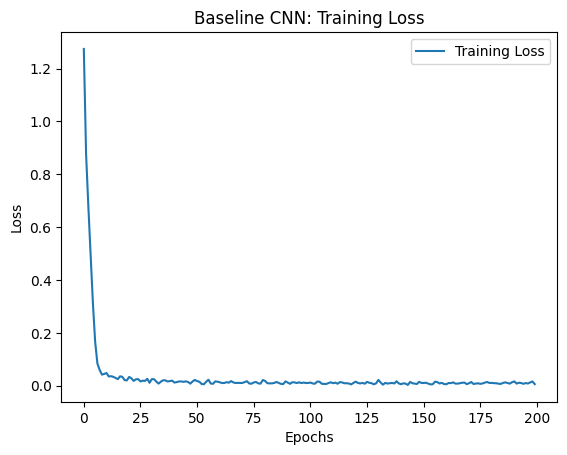


Baseline CNN Results:
Training Time: 3583.24 seconds
Final Training Loss: 0.0060
Test Accuracy: 69.21%


In [ ]:
# Plot training loss
plt.plot(train_losses_1a, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Baseline CNN: Training Loss')
plt.legend()
plt.show()

# Results
print("\nBaseline CNN Results:")
print(f"Training Time: {train_time_1a:.2f} seconds")
print(f"Final Training Loss: {train_losses_1a[-1]:.4f}")
print(f"Test Accuracy: {test_accuracy_1a * 100:.2f}%")

Part b

In [ ]:
# Train and Evaluate Function
def train_and_evaluate(model, train_loader, test_loader, epochs=200, display_progress=False):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()
    train_losses = []
    model.train()

    start_time = time.time()
    for epoch in range(epochs):
        epoch_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        train_losses.append(epoch_loss / len(train_loader))

        # Display progress
        if epoch % 10 == 0:
            print(f"Epoch {epoch}/{epochs}, Loss: {train_losses[-1]:.4f}")

    train_time = time.time() - start_time

    # Evaluate the model
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_accuracy = 100 * correct / total
    return train_losses, test_accuracy, train_time

In [ ]:
# Define Extended CNN Model
class ExtendedCNN(nn.Module):
    def __init__(self):
        super(ExtendedCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.flatten = nn.Flatten()

        flattened_size = 128 * 8 * 8
        self.fc1 = nn.Linear(flattened_size, 256)  # Fully connected layer
        self.fc2 = nn.Linear(256, 10)  # Output layer

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
# Train Extended CNN
print("Training Extended CNN...")
extended_model = ExtendedCNN().to(device)
train_losses_1b, test_accuracy_1b, train_time_1b = train_and_evaluate(extended_model, train_loader, test_loader)

Training Extended CNN...
Epoch 0/200, Loss: 1.3122
Epoch 10/200, Loss: 0.0520
Epoch 20/200, Loss: 0.0305
Epoch 30/200, Loss: 0.0209
Epoch 40/200, Loss: 0.0141
Epoch 50/200, Loss: 0.0186
Epoch 60/200, Loss: 0.0153
Epoch 70/200, Loss: 0.0111
Epoch 80/200, Loss: 0.0136
Epoch 90/200, Loss: 0.0209
Epoch 100/200, Loss: 0.0147
Epoch 110/200, Loss: 0.0105
Epoch 120/200, Loss: 0.0152
Epoch 130/200, Loss: 0.0200
Epoch 140/200, Loss: 0.0155
Epoch 150/200, Loss: 0.0148
Epoch 160/200, Loss: 0.0124
Epoch 170/200, Loss: 0.0275
Epoch 180/200, Loss: 0.0268
Epoch 190/200, Loss: 0.0178


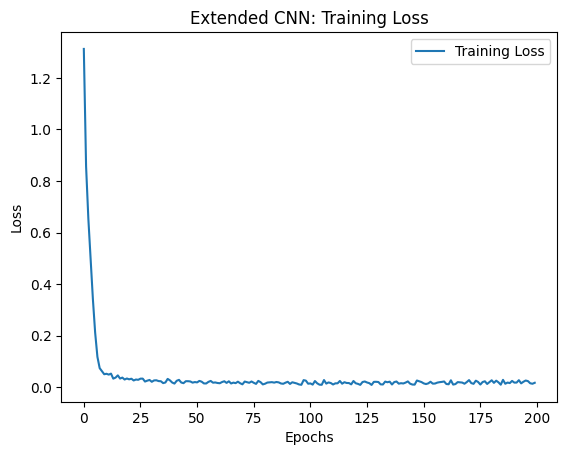


Extended CNN Results:
Training Time: 3990.64 seconds
Final Training Loss: 0.0172
Test Accuracy: 7389.00%


In [ ]:
# Plot training loss
plt.plot(train_losses_1b, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Extended CNN: Training Loss')
plt.legend()
plt.show()

# Results
print("\nExtended CNN Results:")
print(f"Training Time: {train_time_1b:.2f} seconds")
print(f"Final Training Loss: {train_losses_1b[-1]:.4f}")
print(f"Test Accuracy: {test_accuracy_1b * 100:.2f}%")

#Problem 2

In [ ]:
# Import Libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import time
import matplotlib.pyplot as plt

In [ ]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# CIFAR-10 Data Loading
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize images
])

train_dataset = datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)

train_loader = DataLoader(dataset=train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=128, shuffle=False)


Files already downloaded and verified
Files already downloaded and verified


In [ ]:
# Residual Block
class ResBlock(nn.Module):
    def __init__(self, n_chans):
        super(ResBlock, self).__init__()
        self.conv1 = nn.Conv2d(n_chans, n_chans, kernel_size=3, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(n_chans)
        self.conv2 = nn.Conv2d(n_chans, n_chans, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(n_chans)
        torch.nn.init.kaiming_normal_(self.conv1.weight, nonlinearity='relu')
        torch.nn.init.kaiming_normal_(self.conv2.weight, nonlinearity='relu')

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = F.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        return F.relu(out + x)  # Skip connection

In [ ]:
# ResNet-10
class ResNet10(nn.Module):
    def __init__(self, n_chans=64, n_blocks=10):
        super(ResNet10, self).__init__()
        self.conv1 = nn.Conv2d(3, n_chans, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(n_chans)
        self.resblocks = nn.Sequential(*(ResBlock(n_chans) for _ in range(n_blocks)))
        self.fc1 = nn.Linear(n_chans * 8 * 8, 256)
        self.fc2 = nn.Linear(256, 10)  # 10 classes for CIFAR-10

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.max_pool2d(x, 2)
        x = self.resblocks(x)
        x = F.max_pool2d(x, 2)
        x = torch.flatten(x, 1)  # Flatten the tensor
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
# Training and Evaluation Function
def train_and_evaluate(model, train_loader, test_loader, epochs=200, lr=0.01):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    train_losses = []
    test_accuracies = []
    model.train()
    start_time = time.time()

    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # Record training loss
        avg_loss = running_loss / len(train_loader)
        train_losses.append(avg_loss)

        # Evaluate on the test set
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = correct / total
        test_accuracies.append(accuracy)

        model.train()  # Switch back to training mode
        if (epoch + 1) % 10 == 0:  # Print every 10 epochs
            print(f"Epoch [{epoch + 1}/{epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}")

    end_time = time.time()
    training_time = end_time - start_time
    return train_losses, test_accuracies, training_time

In [ ]:
# Initialize and Train the ResNet-10 Model
resnet_model = ResNet10().to(device)
train_losses_resnet, test_accuracies_resnet, train_time_resnet = train_and_evaluate(
    resnet_model, train_loader, test_loader, epochs=200
)

Epoch [10/200], Loss: 0.5779, Accuracy: 0.6865
Epoch [20/200], Loss: 0.2810, Accuracy: 0.6988
Epoch [30/200], Loss: 0.1780, Accuracy: 0.6942
Epoch [40/200], Loss: 0.1334, Accuracy: 0.6993
Epoch [50/200], Loss: 0.1216, Accuracy: 0.6946
Epoch [60/200], Loss: 0.1254, Accuracy: 0.6955
Epoch [70/200], Loss: 0.1124, Accuracy: 0.7002
Epoch [80/200], Loss: 0.1003, Accuracy: 0.6966
Epoch [90/200], Loss: 0.0966, Accuracy: 0.7061
Epoch [100/200], Loss: 0.1074, Accuracy: 0.7067
Epoch [110/200], Loss: 0.0834, Accuracy: 0.7031
Epoch [120/200], Loss: 0.0992, Accuracy: 0.6917
Epoch [130/200], Loss: 0.0994, Accuracy: 0.6986
Epoch [140/200], Loss: 0.1031, Accuracy: 0.7031
Epoch [150/200], Loss: 0.0963, Accuracy: 0.7037
Epoch [160/200], Loss: 0.0803, Accuracy: 0.7015
Epoch [170/200], Loss: 0.0897, Accuracy: 0.7049
Epoch [180/200], Loss: 0.0749, Accuracy: 0.7083
Epoch [190/200], Loss: 0.1207, Accuracy: 0.7077
Epoch [200/200], Loss: 0.0791, Accuracy: 0.7111


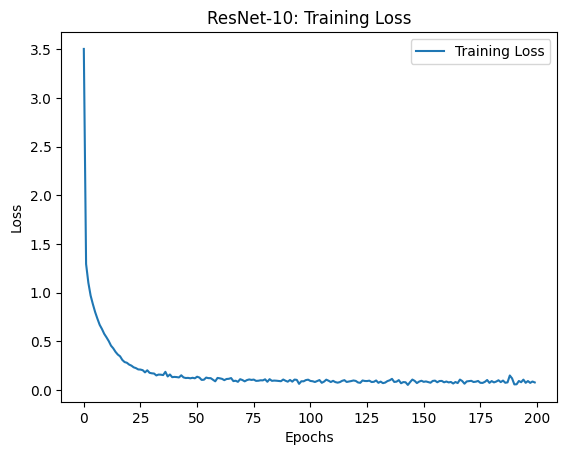

In [ ]:
# Plot training loss
plt.plot(train_losses_resnet, label="Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("ResNet-10: Training Loss")
plt.legend()
plt.show()

In [ ]:
# Results
print("\nResNet-10 Results:")
print(f"Training Time: {train_time_resnet:.2f} seconds")
print(f"Final Training Loss: {train_losses_resnet[-1]:.4f}")
print(f"Test Accuracy: {test_accuracies_resnet[-1] * 100:.2f}%")


ResNet-10 Results:
Training Time: 6684.89 seconds
Final Training Loss: 0.0791
Test Accuracy: 71.11%
